In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
class DQN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        nn_layers = []
        for i in range(len(layers)-1):
            nn_layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                nn_layers.append(nn.ReLU())
        self.layers = nn.Sequential(
            *nn_layers
        )
    def forward(self, X):
        out = self.layers(X)
        return out      

In [5]:
DQN([16, 100, 200, 4])

DQN(
  (layers): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=4, bias=True)
  )
)

In [6]:
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

In [45]:
class FrozenLakeDQL():
    # Hyperparameters
    learning_rate = 0.001
    discount_factor = 0.9
    policy_target_sync = 10
    replay_memory_size = 1000
    mini_batch_size = 32

    loss_fn = nn.MSELoss()

    ACTIONS = ['L', 'D', 'R', 'U']


    def state_to_dqn_input(self, state:int, num_states:int)->torch.Tensor:
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor
    
    def epsilon_greedy(self, policy, env, epsilon, state):
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = policy(self.state_to_dqn_input(state, env.observation_space.n)).argmax().item()
        return action
            
        
        

    def train(self, episodes, is_slippery, render=False):
        replay_memory = ReplayMemory(self.replay_memory_size)
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None)
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        policy = DQN([num_states, 32, 16, num_actions])
        target = DQN([num_states, 32, 16, num_actions])

        target.load_state_dict(policy.state_dict())
        
        print('Policy (random, before training):')
        self.print_dqn(policy)

        self.optimizer = torch.optim.Adam(policy.parameters(), lr=self.learning_rate)

        # List to keep track of rewards collected per episode. Initialize list to 0's.
        rewards_per_episode = np.zeros(episodes)

        # List to keep track of epsilon decay
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count=0
        epsilon = 1 # 1 = 100% random actions

        for i in range(episodes):
            state = env.reset()[0] # Initializing state to 0
            terminated = False # Reacehed goal or fell in hole
            truncated = False # Took 200 actions

            while not truncated and not terminated:     
                action = self.epsilon_greedy(policy, env, epsilon, state)
                new_state,reward,terminated,truncated,_ = env.step(action)
                replay_memory.append((state, action, new_state, reward, terminated))
                state = new_state
                step_count += 1


            if reward == 1:
                rewards_per_episode[i] = 1

            if len(replay_memory) >= self.mini_batch_size and np.sum(rewards_per_episode) > 0:
                mini_batch = replay_memory.sample(self.mini_batch_size)
                self.learn(mini_batch, policy, target, env)

                # Decay epsilon
                epsilon = max(epsilon - (1/episodes), 0)
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.policy_target_sync:
                    target.load_state_dict(policy.state_dict())
                    step_count=0

        # Close environment
        env.close()

        # Save policy
        torch.save(policy.state_dict(), "frozen_lake_dql.pt")

        # Create new graph 
        plt.figure(1)

        # Plot average rewards (Y-axis) vs episodes (X-axis)
        sum_rewards = np.zeros(episodes)
        for x in range(episodes):
            sum_rewards[x] = np.sum(rewards_per_episode[max(0, x-100):(x+1)])
        plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
        plt.plot(sum_rewards)
        
        # Plot epsilon decay (Y-axis) vs episodes (X-axis)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)
        
        # Save plots
        plt.savefig('frozen_lake_dql.png')



    def learn(self, mini_batch, policy, target, env):
        num_states = env.observation_space.n
        current_q_list = []
        target_q_list = []

        
        for state, action, new_state, reward, terminated in mini_batch:
            if terminated: 
                # Agent either reached goal (reward=1) or fell into hole (reward=0)
                # When in a terminated state, target q value should be set to the reward.
                target_val = torch.FloatTensor([reward])
            else:
                # Calculate target q value 
                with torch.no_grad():
                    target_val = torch.FloatTensor(
                        reward + self.discount_factor * target(self.state_to_dqn_input(new_state, num_states)).max()
                    )
            
            policy_q_actions = policy(self.state_to_dqn_input(state, num_states))
            current_q_list.append(policy_q_actions)

            target_q_actions = target(self.state_to_dqn_input(state, num_states))
            target_q_actions[action] = target_val
            target_q_list.append(target_q_actions)

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    # Print DQN: state, best action, q values
    def print_dqn(self, dqn):
        # Get number of input nodes
        num_states = 16

        # Loop each state and print policy to console
        for s in range(num_states):
            #  Format q values for printing
            q_values = ''
            for q in dqn(self.state_to_dqn_input(s, num_states)).tolist():
                q_values += "{:+.2f}".format(q)+' '  # Concatenate q values, format to 2 decimals
            q_values=q_values.rstrip()              # Remove space at the end

            # Map the best action to L D R U
            best_action = self.ACTIONS[dqn(self.state_to_dqn_input(s, num_states)).argmax()]

            # Print policy in the format of: state, action, q values
            # The printed layout matches the FrozenLake map.
            print(f'{s:02},{best_action},[{q_values}]', end=' ')         
            if (s+1)%4==0:
                print() # Print a newline every 4 states




Policy (random, before training):
00,L,[+0.23 +0.08 +0.19 +0.21] 01,L,[+0.21 +0.07 +0.18 +0.21] 02,U,[+0.21 +0.09 +0.17 +0.24] 03,U,[+0.21 +0.05 +0.18 +0.21] 
04,U,[+0.21 +0.08 +0.14 +0.22] 05,U,[+0.19 +0.07 +0.15 +0.22] 06,U,[+0.21 +0.09 +0.20 +0.22] 07,U,[+0.21 +0.09 +0.15 +0.23] 
08,U,[+0.20 +0.07 +0.16 +0.21] 09,U,[+0.19 +0.05 +0.13 +0.22] 10,U,[+0.20 +0.08 +0.17 +0.23] 11,U,[+0.19 +0.05 +0.15 +0.22] 
12,U,[+0.18 +0.09 +0.19 +0.23] 13,L,[+0.21 +0.07 +0.16 +0.21] 14,R,[+0.20 +0.06 +0.23 +0.20] 15,U,[+0.22 +0.10 +0.13 +0.23] 


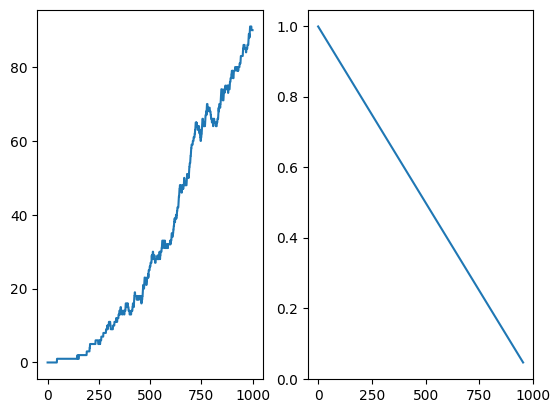

In [47]:
frozen_lake = FrozenLakeDQL()
is_slippery = False
frozen_lake.train(1000, is_slippery=is_slippery)